## Embeddings

In this notebook the construction of `w2v` and `fasttext` embeddings will be given.

For the final implementation `fasttext` will be chosen primarily because of the possibility of quantization

In [ ]:
!pip install gensim

In [1]:
import pandas as pd
import numpy as np
from gensim.models import FastText, Word2Vec

In [2]:
train = pd.read_csv('train-preprocessed.csv')
test = pd.read_csv('test-preprocessed.csv')

In [3]:
train['code'] = train['code'].apply(str.split)
test['code'] = test['code'].apply(str.split)

In [4]:
VEC_SIZE=150

In [5]:
w2v = Word2Vec(window=3, workers=16, negative=10, vector_size=VEC_SIZE, seed=42)

In [6]:
w2v.build_vocab(corpus_iterable=train['code'].values)
w2v.train(corpus_iterable=train['code'].values,  total_examples=train.shape[0], epochs=10)

(12589201, 22772280)

In [7]:
def safe_get_embedding(model, word, vec_size):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros(shape=(vec_size,))

In [8]:
def get_emb_matrix(X, model):
    embeddings = []
    for example in X:
        embs = [safe_get_embedding(model, word, VEC_SIZE) for word in example]
        avg = sum(embs) / len(embs)
        embeddings.append(avg)
    return np.stack(embeddings, axis=0)

In [9]:
y_train = train['language']
y_test = test['language']

In [10]:
X_train_embeddings = get_emb_matrix(train['code'], w2v)

In [11]:
X_test_embeddings = get_emb_matrix(test['code'], w2v)

In [12]:
X_train_embeddings.shape, X_test_embeddings.shape

((11283, 150), (3762, 150))

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [14]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42).fit(X_train_embeddings, y_train)

In [15]:
preds = clf.predict(X_test_embeddings)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           c       0.86      0.96      0.91       229
         cpp       0.96      0.87      0.91       230
         css       0.97      0.97      0.97       220
     haskell       0.94      0.92      0.93       221
        html       0.94      0.95      0.94       240
        java       0.95      0.95      0.95       216
  javascript       0.94      0.96      0.95       219
         lua       0.94      0.93      0.94       218
        objc       0.99      0.95      0.97       243
        perl       0.97      0.96      0.96       225
         php       0.96      0.95      0.96       237
      python       0.84      0.88      0.86       225
           r       0.90      0.93      0.91       214
        ruby       0.89      0.87      0.88       208
       scala       0.93      0.98      0.96       198
      sqlite       0.97      0.94      0.95       209
       swift       0.98      0.95      0.97       210

    accuracy              

In [7]:
fst = FastText(window=3, workers=16, sg=1, negative=5)
fst.build_vocab(corpus_iterable=train['code'].values)
fst.train(corpus_iterable=train['code'].values,  total_examples=train.shape[0], epochs=10)

(12586232, 22772280)

In [8]:
fst.save('fasttext-embeddings.bin')

In [18]:
X_train_embeddings = get_emb_matrix(train['code'], fst)
X_test_embeddings = get_emb_matrix(test['code'], fst)

In [19]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42).fit(X_train_embeddings, y_train)

In [20]:
preds = clf.predict(X_test_embeddings)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           c       0.85      0.96      0.90       229
         cpp       0.93      0.86      0.89       230
         css       0.99      0.98      0.98       220
     haskell       0.95      0.91      0.93       221
        html       0.97      0.97      0.97       240
        java       0.95      0.96      0.95       216
  javascript       0.94      0.95      0.95       219
         lua       0.92      0.94      0.93       218
        objc       0.98      0.93      0.96       243
        perl       0.97      0.94      0.95       225
         php       0.92      0.92      0.92       237
      python       0.86      0.85      0.85       225
           r       0.93      0.97      0.95       214
        ruby       0.90      0.86      0.88       208
       scala       0.94      0.96      0.95       198
      sqlite       0.97      0.95      0.96       209
       swift       0.96      0.95      0.95       210

    accuracy              

In [21]:
w2v.wv.most_similar(positive=['if'])

[('while', 0.5760221481323242),
 ('elseif', 0.5655128359794617),
 ('assert', 0.4731639325618744),
 ('else', 0.4389866590499878),
 ('continue', 0.41360852122306824),
 ('next', 0.3935346007347107),
 ('eof', 0.38830214738845825),
 ('&', 0.38471555709838867),
 ('null', 0.37266039848327637),
 ('elsif', 0.368747353553772)]

In [22]:
fst.wv.most_similar(positive=['if'])

[('elsif', 0.6311429738998413),
 ('else', 0.6281177401542664),
 ('elseif', 0.6139234304428101),
 ('while', 0.5696681141853333),
 ('curr.next', 0.5611851811408997),
 ('copyofstart', 0.558885931968689),
 ('previousstate', 0.5529688596725464),
 ('numprevioustouches', 0.5424906015396118),
 ('cancel_upload', 0.5387269854545593),
 ('curr_tok', 0.5377238392829895)]

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [24]:
def tsne_plot(model, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
        tokens.append(safe_get_embedding(model, word, VEC_SIZE))
        labels.append(word)
    
    tokens = np.array(tokens)
    labels = np.array(labels)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [25]:
words = [
    'self', 'this', 'foo', 'bar', 'for', 'if', 'else',
    '#include', 'template', 'void', 'int', 'malloc', 'def',
    'yield', 'iostream', 'elif', 'int', 'char',
    ';', '(', ')', 'dict', 'list', '[', ']', 'import',
    'function', 'friend', 'os', 'eggs', 'return', 'auto',
    'unsigned', 'explicit', 'inline', 'enum', '&&', '||',
    'and', 'or', 'elif', 'let', 'var'
]

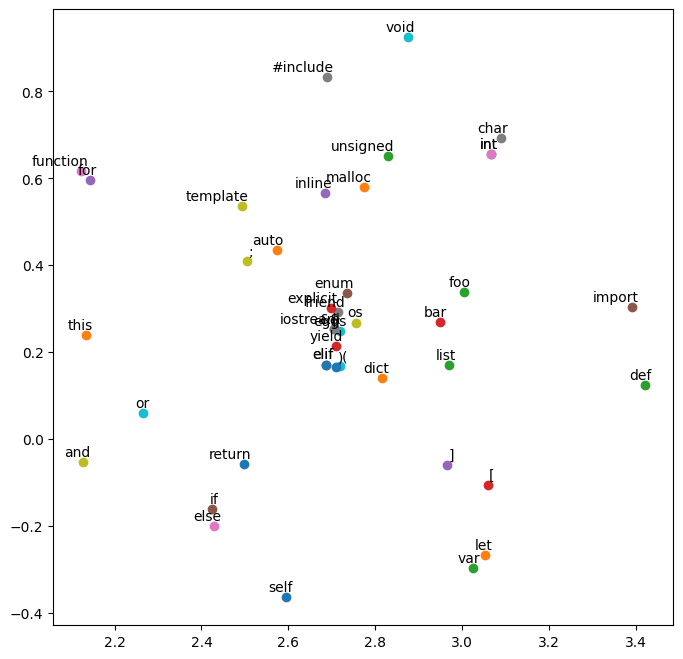

In [26]:
tsne_plot(w2v, words)

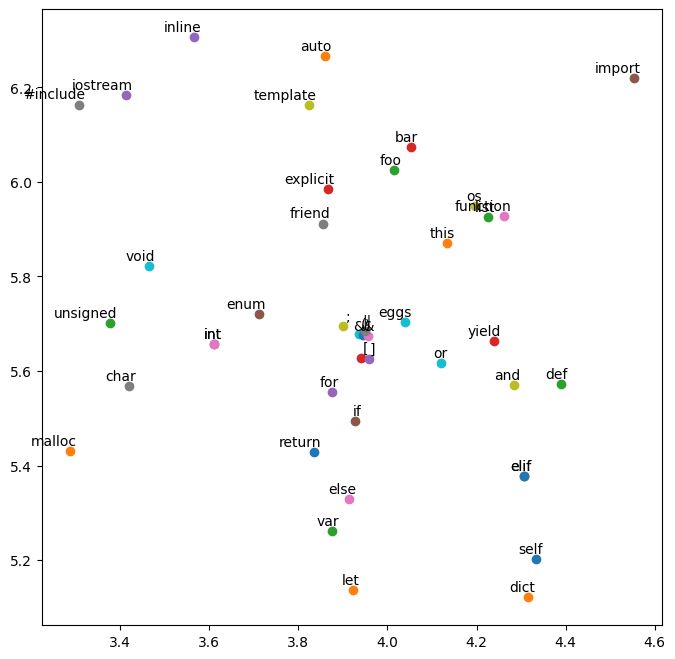

In [27]:
tsne_plot(fst, words)